In [2]:
from IPython.core.display import HTML
with open('../style.css') as file:
    css = file.read()
HTML(css)

# Huffman's Algorithm for Lossless Data Compression

In [3]:
import graphviz as gv

This notebook presents <em style="color:blue;">coding trees</em>.  Given an alphabet $\Sigma$ of characters, 
we define the set $\mathcal{K}$ of coding trees by induction:

  - $\texttt{Leaf}(c,f) \in \mathcal{K} $ if $c \in \Sigma$ and $f \in \mathbb{N}$

    An expression of the form $\texttt{Leaf}(c,f)$ represent a *leaf* in a coding tree.  Here  $c$ is a letter
    from the alphabet $\Sigma$ and $f$ is the number of times that the letter $c$ occurs in the string $s$
    that is to be encoded.

  - $\texttt{Node}(l,r) \in \mathcal{K}$ if $l \in\mathcal{K}$ and $r \in \mathcal{K}$

    The expressions $\texttt{Node}(l,r)$ represent the *inner nodes* of the coding-tree.

The class `CodingTree` is a *superclass* for constructing coding trees.  It has one static variable `sNodeCount`.  This variable is used to equip all nodes with a unique identifier.  This identifier is used to draw the trees using [graphviz](https://graphviz.org/).

Every object of class `CodingTree` has a uniques identifier `mID` that is stored as a member variable.  This identifier is only used by `graphviz`.

In [4]:
class CodingTree:
    sNodeCount = 0
    
    def __init__(self):
        CodingTree.sNodeCount += 1
        self.mID = CodingTree.sNodeCount
        
    def count(self):
        "compute the number of characters"
        pass
        
    def cost(self):
        "compute the number of bits used by this coding tree"
        pass
        
    def getID(self):
        return self.mID  # used only by graphviz

The function `make_string` is a helper function that is used to simplify the implementation of `__str__`.
  - `self` is the object that is to be rendered as a string
  - `attributes` is a list of those member variables that are used to produce the string

In [5]:
def _make_string(self, Attributes):
        # map the function __str__ to all attributes and join them with a comma
        name = self.__class__.__name__
        return f"{name}({', '.join(map(str, [getattr(self, at) for at in Attributes]))})"
    
CodingTree._make_string = _make_string

The method $t.\texttt{toDot}()$ takes a binary trie $t$ and returns a graph that depicts the tree $t$.

In [6]:
def toDot(self):
    dot = gv.Digraph(node_attr={'shape': 'record', 'style': 'rounded'})
    nodeDict = {}
    self._collectIDs(nodeDict)
    for n, t in nodeDict.items():
        if isinstance(t, Leaf):
            if t.mCharacter == ' ':
                dot.node(str(n), label='{ \' \' |' + "{:,}".format(t.mFrequency) + '}') 
            elif t.mCharacter == '\t':
                dot.node(str(n), label='{ \'\\\\t\' |' + "{:,}".format(t.mFrequency) + '}') 
            elif t.mCharacter == '\n':
                dot.node(str(n), label='{ \'\\\\n\' |' + "{:,}".format(t.mFrequency) + '}')     
            elif t.mCharacter == '\v':
                dot.node(str(n), label='{ \'\\\\v\' |' + "{:,}".format(t.mFrequency) + '}')     
            else:
                dot.node(str(n), label='{' + str(t.mCharacter) + '|' + "{:,}".format(t.mFrequency) + '}') 
        elif isinstance(t, Node):
            dot.node(str(n), label="{:,}".format(t.count()))
        else:
            assert False, f'Unknown node {t}'
    for n, t in nodeDict.items():
        if isinstance(t, Node):
            dot.edge(str(n), str(t.mLeft .getID()), label='0')
            dot.edge(str(n), str(t.mRight.getID()), label='1')
    return dot

CodingTree.toDot = toDot

The method $t.\texttt{collectIDs}(d)$ takes a coding tree $t$ and a dictionary $d$ and updates the dictionary so that the following holds:
$$ d[\texttt{id}] = n \quad \mbox{for every node $n$ in $t$.} $$
Here, $\texttt{id}$ is the unique identifier of the node $n$, i.e. $d$ associates the identifiers with the corresponding nodes.

In [7]:
def _collectIDs(self, nodeDict):
    nodeDict[self.getID()] = self
    if isinstance(self, Node):
        self.mLeft ._collectIDs(nodeDict)
        self.mRight._collectIDs(nodeDict)
        
CodingTree._collectIDs = _collectIDs

The class `Leaf` represents a leaf of the form $\texttt{Leaf}(c, f)$.  It maintains two member variables.
  - $c$ represents the character that is encoded.  This character is stored in the member variable `mCharacter`.
  - $f$ represents the number of occurrences of the character $c$ in the string $s$ that is to be encoded and is stored in the member variable `mFrequancy`.

In [8]:
class Leaf(CodingTree):
    def __init__(self, c, f):
        CodingTree.__init__(self)
        self.mCharacter = c
        self.mFrequency = f
        
    def count(self):
        return self.mFrequency
    
    def cost(self):
        return 0
    
    def __str__(self):
        return _make_string(self, ['mCharacter', 'mFrequency'])
    
    def __lt__(self, other):
        if isinstance(other, Node):
            return True
        return self.mCharacter < other.mCharacter

The class `Node` represents an inner node of the form $\texttt{Node}(l, r)$.  It maintains two member variables:
  - `self.mLeft` is the left subtree $l$,
  - `self.mRight` is the right subtree $r$.

In [9]:
class Node(CodingTree):
    def __init__(self, l, r):
        CodingTree.__init__(self)
        self.mLeft  = l
        self.mRight = r

    def count(self):
        return self.mLeft.count() + self.mRight.count()
        
    def cost(self):
        return self.mLeft.cost() + self.mRight.cost() + self.count()
    
    def __str__(self):
        return _make_string(self, ['mLeft', 'mRight'])
    
    def __lt__(self, other):
        if isinstance(other, Leaf):
            return False
        return self.mLeft < other.mLeft

## Building a Coding Tree

The module `heapq` provides priority queues.  The api is given at https://docs.python.org/3/library/heapq.html.
This module represents heaps as arrays.

In [10]:
import heapq

In [11]:
H = []
heapq.heappush(H, 7)
heapq.heappush(H, 1)
heapq.heappush(H, 0)
heapq.heappush(H, 6)
H

[0, 6, 1, 7]

In [12]:
a = heapq.heappop(H)
print('a = ', a)
H

a =  0


[1, 6, 7]

The function `coding_tree` implements [Huffman's algorithm](https://en.wikipedia.org/wiki/Huffman_coding) for data compression. 
The input $M$ is a set of pairs of the form
$$ \bigl\{ (c_1, f_1), \cdots, (c_k, f_k)\bigr\} $$
where $c_i$ is a character and $f_i$ is the number of times this character occurs in the string $s$ that is to be encoded.  Huffman's algorithm is
<em style="color:blue;">greedy</em>:  It always combines those coding trees that have the *least* character count so far as this results in the smallest cost increase.

The heap `H` that is maintained by this function is a priority queue which is represented by an array that is structured as a heap.  The items in this priority queue are pairs of the form
$$ \bigl( t.\texttt{count}(), t \bigr)  $$
where $t$ is a coding tree and $t.\texttt{count}()$ is the count of this coding tree.

In [13]:
def coding_tree(M):
    H = []  # empty priority queue
    for c, f in M:
        heapq.heappush(H, (f, Leaf(c, f)))
    while len(H) > 1:
        a = heapq.heappop(H)
        b = heapq.heappop(H)
        heapq.heappush(H, (a[0] + b[0], Node(a[1], b[1])))
    return H[0][1]

Let us test this with a trivial example.

In [14]:
import math

The function `log2(n)` computes $\log_2(n)$.

In [15]:
def log2(n):
    return math.log(n) / math.log(2)

In [16]:
log2(8)

3.0

In [17]:
def demo(M):
    K = coding_tree(M)
    n = math.ceil(log2(len(M)))
    cost_huffman  = K.cost()
    cost_constant = n * K.count()
    savings       = (cost_constant - cost_huffman) / cost_constant
    print(f'cost of encoding with Huffman coding tree : {"{:,}".format(cost_huffman)} bits')
    print(f'cost of encoding with {n} bits              : {"{:,}".format(cost_constant)} bits')
    print(f'savings: {100 * savings}%')
    return K

cost of encoding with Huffman coding tree : 1,012 bits
cost of encoding with 2 bits              : 2,000 bits
savings: 49.4%


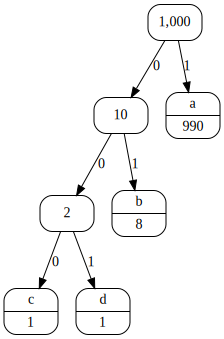

In [18]:
K = demo({ ('a', 990), ('b', 8), ('c', 1), ('d', 1) })
K.toDot()

cost of encoding with Huffman coding tree : 502 bits
cost of encoding with 3 bits              : 609 bits
savings: 17.569786535303777%


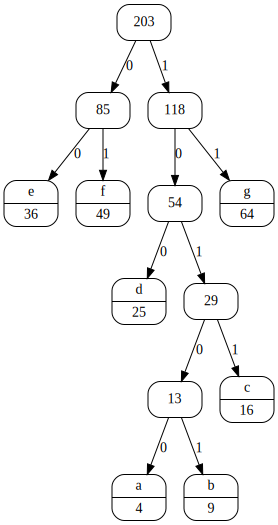

In [19]:
K = demo({ ('a', 4), ('b', 9), ('c', 16), ('d', 25), ('e', 36), ('f', 49), ('g', 64) })
K.toDot()

cost of encoding with Huffman coding tree : 173 bits
cost of encoding with 4 bits              : 220 bits
savings: 21.363636363636363%


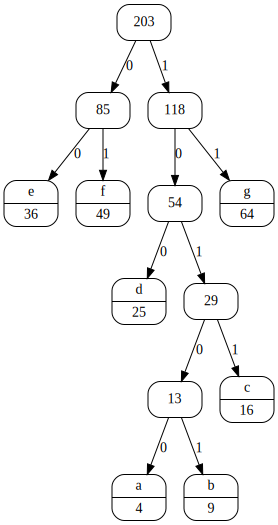

In [20]:
demo({ ('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10) })
K.toDot()

cost of encoding with Huffman coding tree : 78 bits
cost of encoding with 3 bits              : 99 bits
savings: 21.21212121212121%


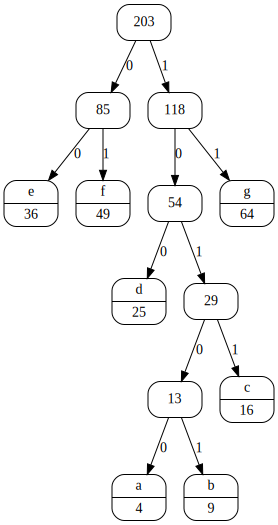

In [21]:
demo({ ('a', 1), ('b', 1), ('c', 2), ('d', 3), ('e', 5), ('f', 8), ('g', 13) })
K.toDot()

The function `demo_file(fn)` reads the file with name `fn`  and calculates the frequency of all characters occurring in `fn`.  Using these frequencies it computes the Huffman coding tree.

In [22]:
def demo_file(fn):
    with open(fn, 'r') as file:
        s = file.read() # read file as string s
    Frequencies = {}
    for c in s:
        f = Frequencies.get(c, 0)
        if f != 0:
            Frequencies[c] += 1
        else:
            Frequencies[c] = 1
    M = { (c, f) for (c, f) in Frequencies.items() }
    print(M)
    return demo(M)

{('?', 202), ('F', 74), ('W', 237), ('Y', 114), ('A', 638), ('Q', 84), ('M', 200), ('G', 83), ('z', 77), ('m', 1907), ('r', 5297), ('c', 2254), ('o', 7970), ('*', 60), ('K', 82), (')', 55), ('(', 56), ('J', 8), ('"', 113), ('l', 4618), ('S', 218), ('R', 140), ('I', 733), ('.', 978), ('D', 192), ('k', 1076), ('i', 6781), ('0', 1), (',', 2418), ('w', 2438), ('v', 804), (']', 2), ('u', 3402), ('j', 138), ('X', 4), (';', 194), ('E', 188), ('H', 284), ('3', 1), ('Z', 1), ('p', 1460), ('_', 4), ('T', 472), ('O', 176), ('y', 2150), ('b', 1384), ('B', 91), ('q', 125), ('!', 450), ('L', 98), ('x', 144), ('d', 4739), ('a', 8153), ('\n', 3604), ('-', 669), ('[', 2), ('g', 2448), ('f', 1927), ('P', 64), (' ', 28918), ('e', 13386), ('t', 10217), ('N', 120), ("'", 1763), ('U', 66), ('s', 6282), ('h', 7090), (':', 233), ('C', 145), ('`', 1109), ('V', 42), ('n', 6896)}
cost of encoding with Huffman coding tree : 676,663 bits
cost of encoding with 7 bits              : 1,039,843 bits
savings: 34.926426

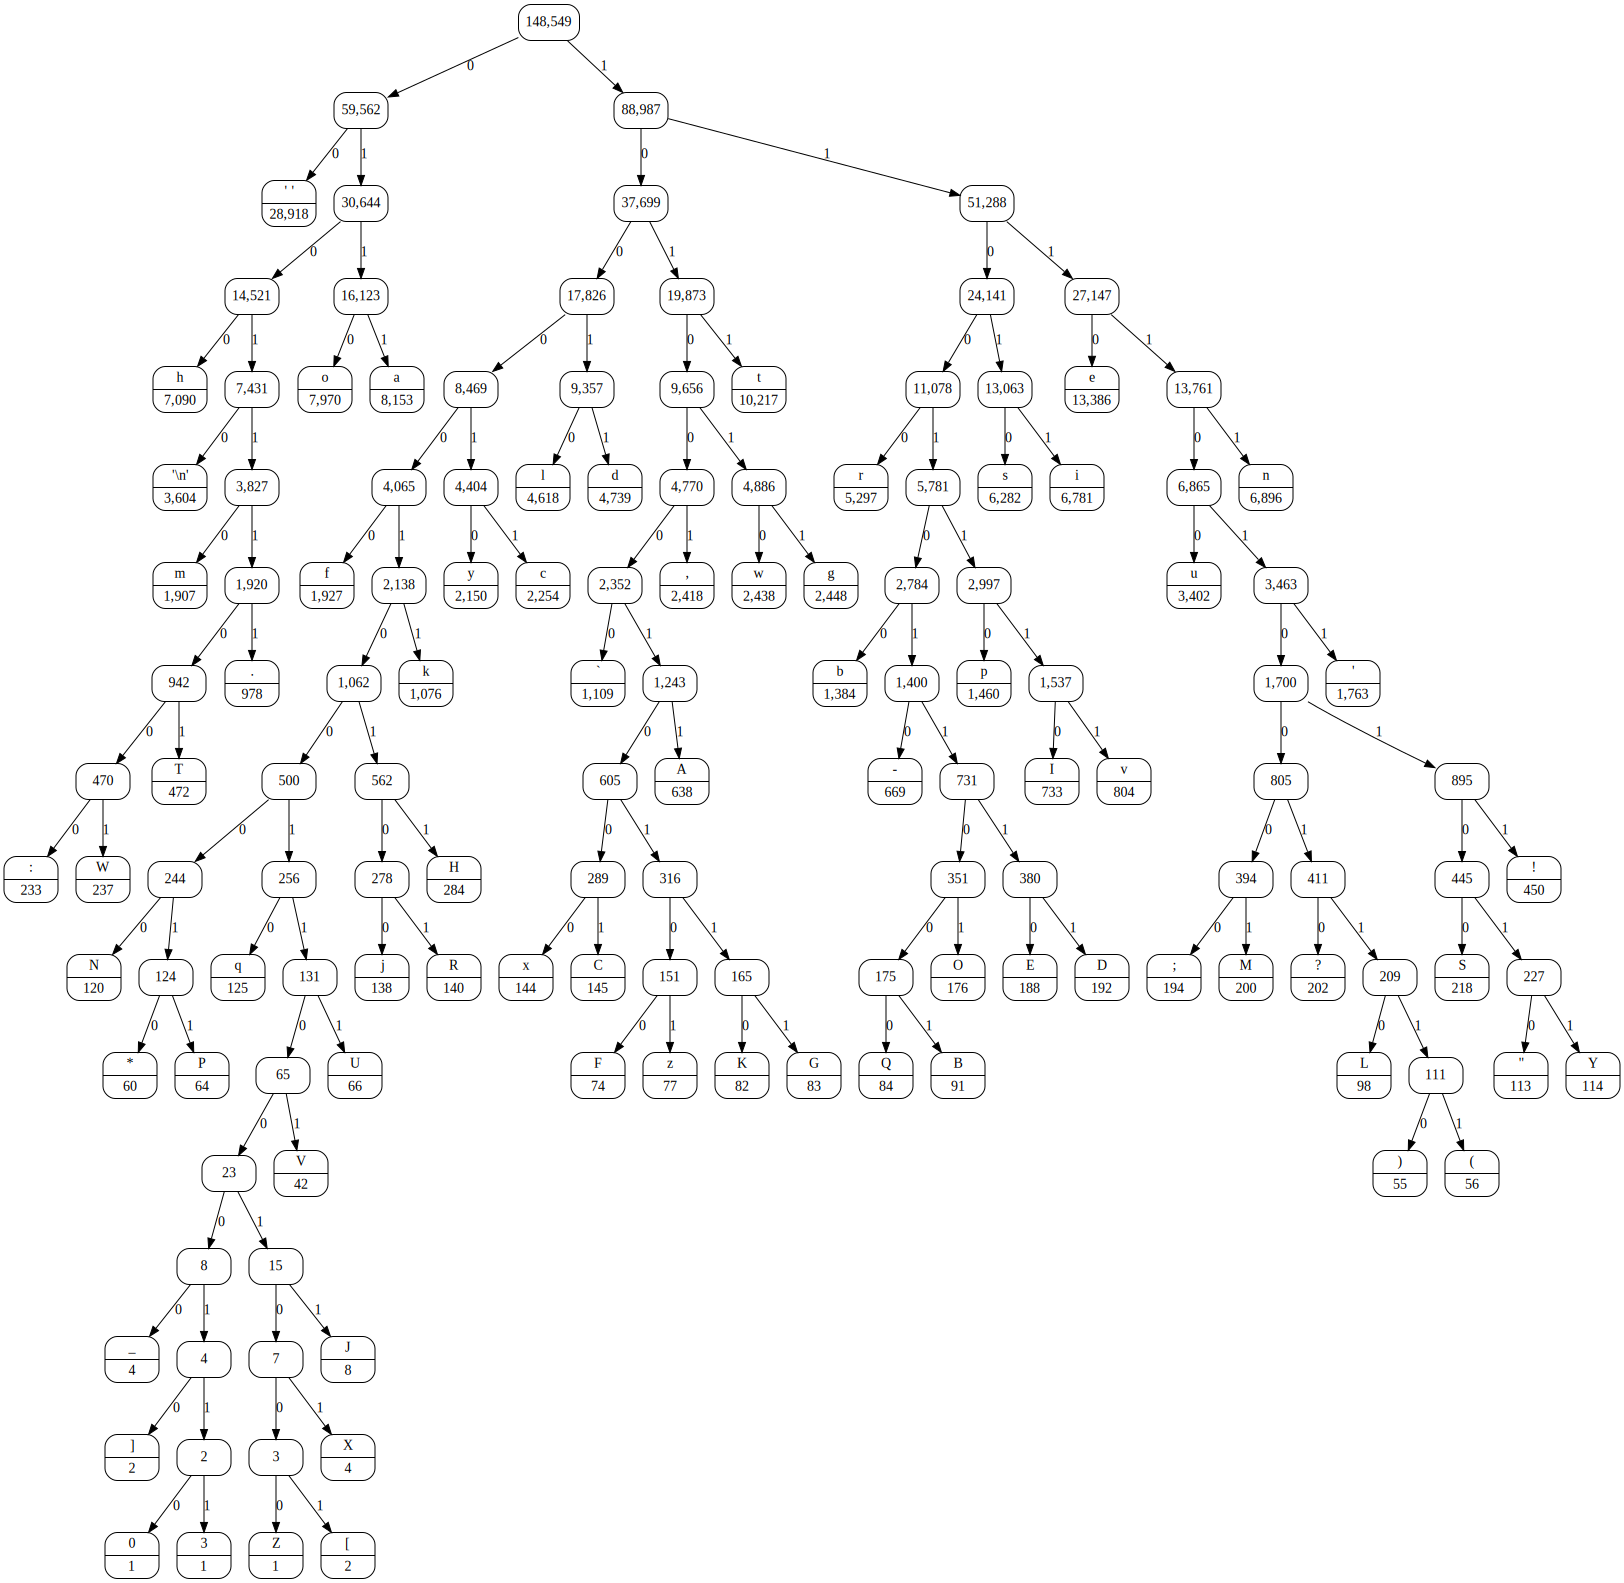

In [23]:
K = demo_file('alice.txt')
K.toDot()

{('2', 54), ('S', 1967), ('m', 22229), ('t', 84349), ('3', 45), ('U', 178), ('H', 1292), ('e', 114118), ('a', 74117), ('z', 589), ('O', 772), (':', 192), ('q', 1224), ('i', 61040), (')', 200), ('Q', 320), ('9', 31), ('k', 7799), ('V', 134), ('(', 200), ('4', 34), ('x', 991), ('M', 676), ('f', 19743), ('W', 1210), ('*', 45), (';', 4143), ('J', 243), ('5', 52), ('$', 2), ('s', 61138), ('8', 47), ('0', 123), ('p', 15970), ('E', 905), ('T', 2202), ('d', 36996), ('D', 661), ('1', 123), ('N', 981), ('I', 3342), ('[', 2), ('P', 991), ('"', 2878), ('X', 15), ('\n', 21213), ('w', 20564), ('C', 1041), ('.', 7385), ('Y', 281), ('v', 8285), ('r', 50519), ('l', 41316), ('h', 60487), (',', 18947), ('?', 999), ('7', 47), ('A', 2377), ('u', 26138), ("'", 2848), ('6', 31), ('F', 732), (']', 2), ('!', 1741), ('K', 139), ('o', 67363), ('n', 63573), ('c', 21101), ('g', 19918), ('b', 15238), ('j', 818), (' ', 190501), ('&', 2), ('R', 639), ('B', 1363), ('y', 16322), ('Z', 34), ('G', 575), ('L', 735), ('-',

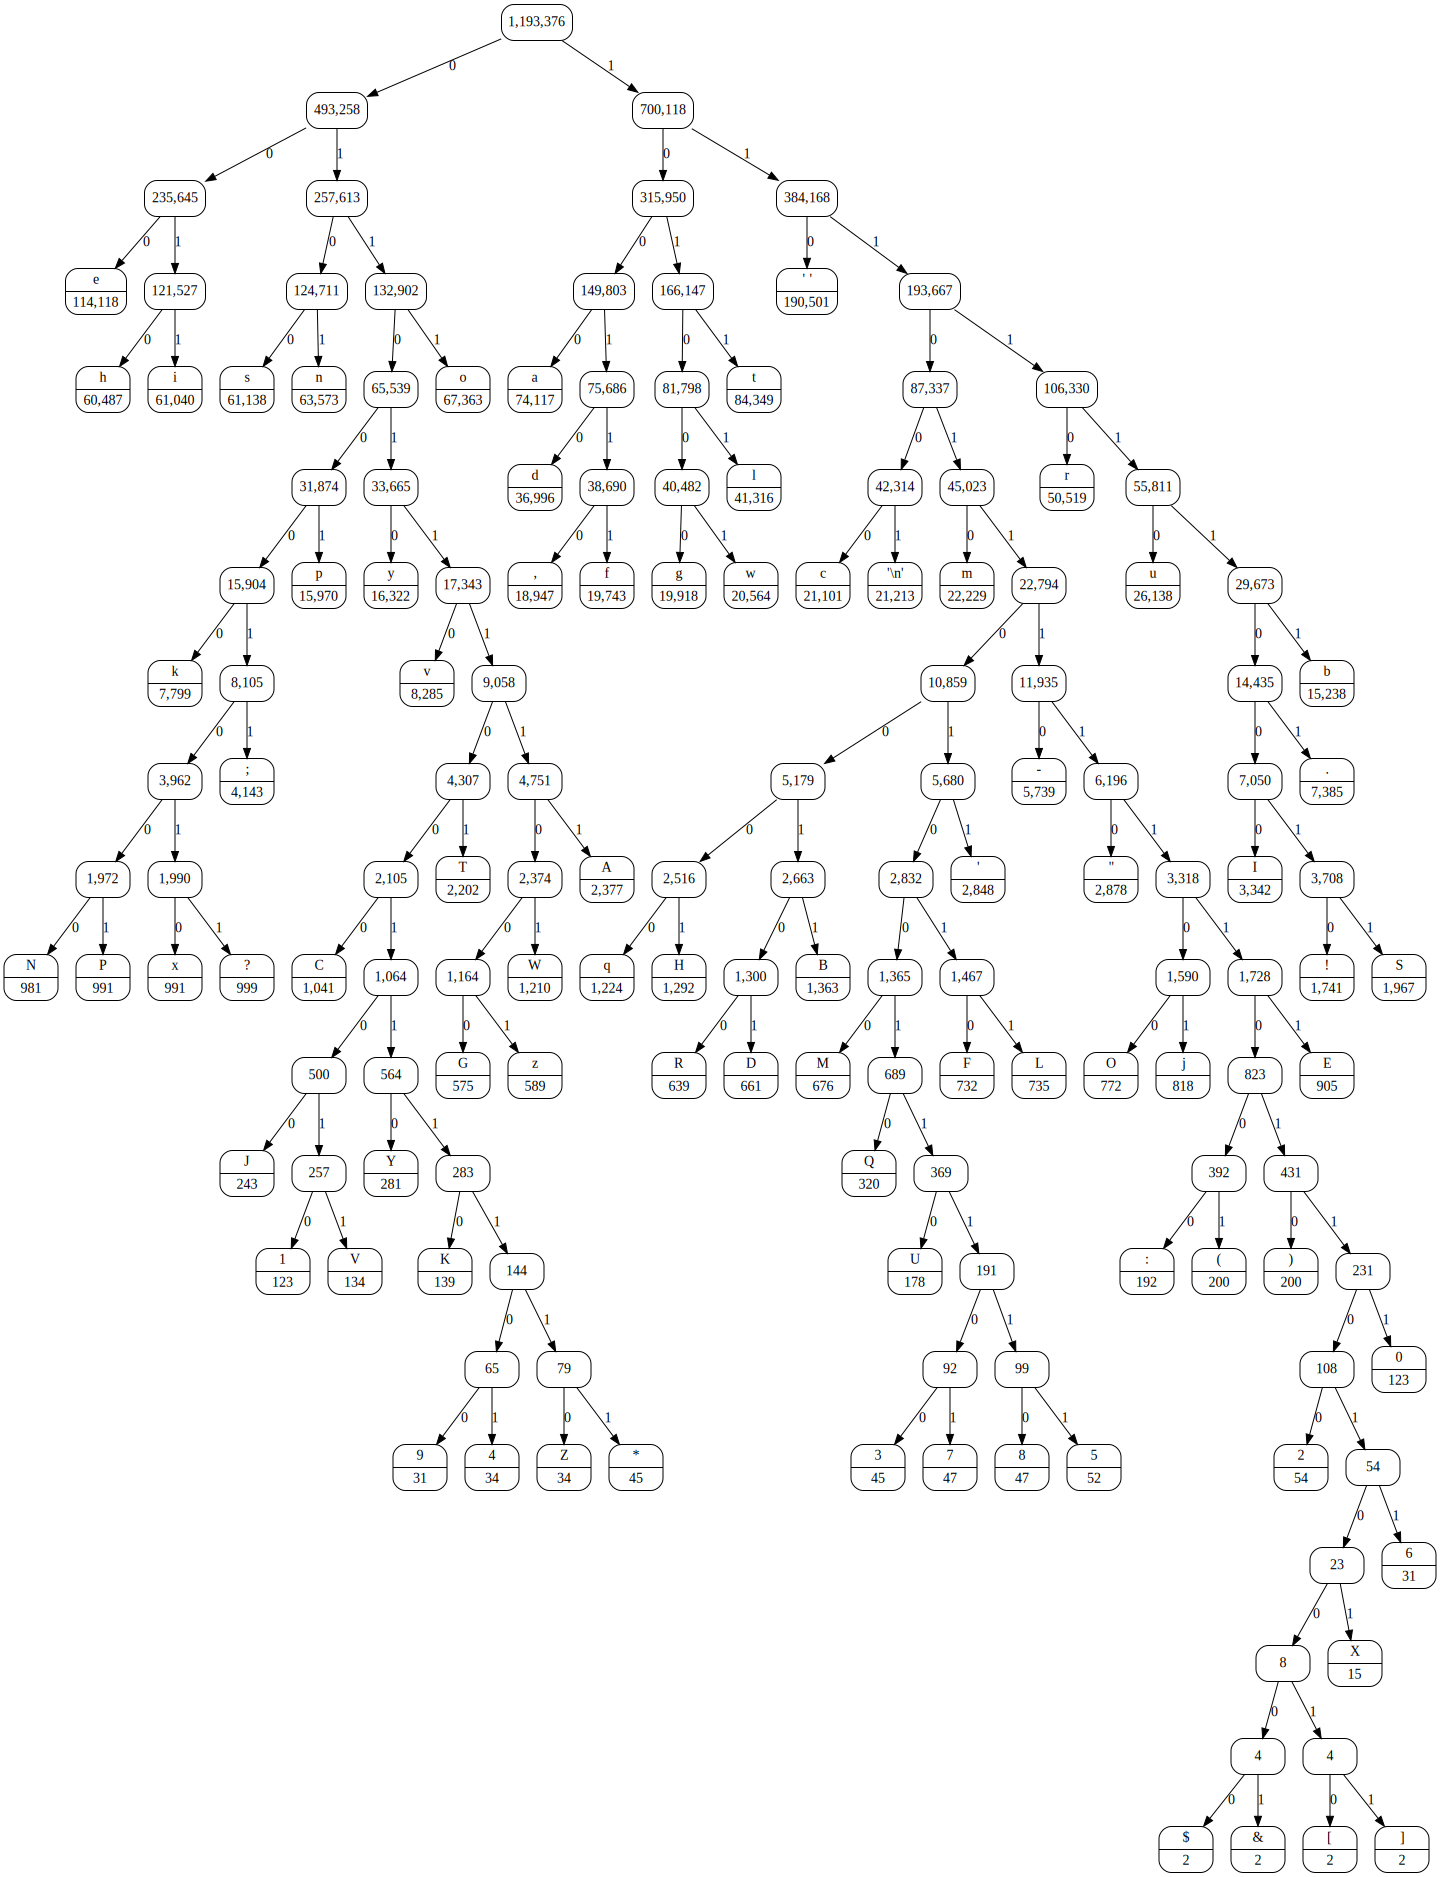

In [24]:
K = demo_file('moby-dick.txt')
K.toDot()

## The Functions `encode` and `decode`

In this section, our aim is to implement two functions.
* $\texttt{encode}: \mathcal{K} \times \Sigma^* \rightarrow \{0,1\}^*$

  Given a coding tree $k$ and a string $s$, the function $\texttt{encode}(k, s)$ encodes the string $s$ into a binary string.
* $\texttt{decode}: \mathcal{K} \times \{0,1\}^* \rightarrow \Sigma^*$

  Given a coding tree $k$ and a binary string $b$, the function $\texttt{decode}(k, b)$ decodes the string $b$ into a string $s \in \Sigma^*$.
  
In order to define the function `encode`, we need an auxilliary function `allCodes` that has the following signature:
$$ \texttt{allCodes} : \mathcal{K} \times \{0,1\}^* \rightarrow \texttt{Dictionary}\langle \Sigma, \{0,1\}^*\rangle $$
The function `allCodes` takes a coding tree $k$ and a binary string $p$ and returns a dictionary mapping the characters stored in $k$ to 
the binary strings that lead to these characters in the coding tree.
The second argument $p$ is needed for the recursive definition to accumulate the prefixes.  On the initial call, $p$ is the 
empty string.  The function `allCodes` is defined via the following equations:
* $\texttt{Leaf}(c, f).\texttt{allCodes}(p) = \{ c \mapsto p \}$,
* $\texttt{Node}(l, r).\texttt{allCodes}(p) = l.\texttt{allCodes}(p+\texttt{'0'}) \cup r.\texttt{allCodes}(p+\texttt{'1'})$.

  In the expressions $p+\texttt{'0'}$ and $p+\texttt{'1'}$ the operator "$+$" denotes string concatenation.

In [25]:
def allCodes(self, p):
    return { self.mCharacter: p }

Leaf.allCodes = allCodes
del allCodes

The implementation of `allCodes` for the class `Node` uses the union operator for dictionaries `'|'`, which is availables since Python `3.9`.
On older versions of Python, the method `update` achieves the same effect, i.e. we would need to write
```
    return self.mLeft.allCodes(p + '0').update(self.mRight.allCodes(p + '1'))
```

In [26]:
def allCodes(self, p):
    return self.mLeft.allCodes(p + '0') | self.mRight.allCodes(p + '1')

Node.allCodes = allCodes
del allCodes

In [27]:
Coding = K.allCodes('')
Coding

{'e': '000',
 'h': '0010',
 'i': '0011',
 's': '0100',
 'n': '0101',
 'k': '0110000',
 'N': '0110001000',
 'P': '0110001001',
 'x': '0110001010',
 '?': '0110001011',
 ';': '01100011',
 'p': '011001',
 'y': '011010',
 'v': '0110110',
 'C': '0110111000',
 'J': '011011100100',
 '1': '0110111001010',
 'V': '0110111001011',
 'Y': '011011100110',
 'K': '0110111001110',
 '9': '011011100111100',
 '4': '011011100111101',
 'Z': '011011100111110',
 '*': '011011100111111',
 'T': '011011101',
 'G': '01101111000',
 'z': '01101111001',
 'W': '0110111101',
 'A': '011011111',
 'o': '0111',
 'a': '1000',
 'd': '10010',
 ',': '100110',
 'f': '100111',
 'g': '101000',
 'w': '101001',
 'l': '10101',
 't': '1011',
 ' ': '110',
 'c': '111000',
 '\n': '111001',
 'm': '111010',
 'q': '1110110000',
 'H': '1110110001',
 'R': '11101100100',
 'D': '11101100101',
 'B': '1110110011',
 'M': '11101101000',
 'Q': '111011010010',
 'U': '1110110100110',
 '3': '111011010011100',
 '7': '111011010011101',
 '8': '11101101001

The function `encode` satisfies the following equation:
$$ \texttt{encode}(K, s) = \sum\limits_{c \in s} K.\texttt{allCodes('')}[c]$$
Here, the summation symbol $\sum$ is interpreted as string concatenation.

In [28]:
def encode(k, s):
    D = k.allCodes('')
    result = ''
    for c in s:
        result += D[c]
    return result

In order to implement the function `decode`, we need an auxilliary function `decodeAux` that is specified as 
as follows:
- $\texttt{Leaf}(c, f).\texttt{decode_aux}(K, \varepsilon) = c$ 
- $b \not= \varepsilon \rightarrow \texttt{Leaf}(c, f).\texttt{decodeAux}(K, b) = c + K.\texttt{decodeAux}(K,b)$ 

  Here $\varepsilon$ denotes the empty string $\texttt{''}$.
- $\texttt{Node}(l, r).\texttt{decodeAux}(K, \texttt{'0'}+d) = l.\texttt{decodeAux}(K, d)$
- $\texttt{Node}(l, r).\texttt{decodeAux}(K, \texttt{'1'}+d) = r.\texttt{decodeAux}(K, d)$

In [29]:
def decodeAux(self, k, b):
    if b == '':
        return self.mCharacter
    return self.mCharacter + k.decodeAux(k, b)

Leaf.decodeAux = decodeAux
del decodeAux

In [34]:
def decodeAux(self, k, b):
    if b[0] == '0':
        return self.mLeft.decodeAux(k, b[1:])
    elif b[0] == '1':
        return self.mRight.decodeAux(k, b[1:])
    else:
        assert False
        
Node.decodeAux = decodeAux
del decodeAux

Now `decode` can be specified as follows:
$$ K.\texttt{decode}(b) = K.\texttt{decodeAux}(K, b)$$

In [31]:
def decode(K, b):
    return K.decodeAux(K, b)

In [32]:
b = encode(K, 'Moby Dick')
b

'11101101000011111111110110101101110110010100111110000110000'

In [35]:
s = decode(K, b)
s

'Moby Dick'